# Piecewise Linear Regression - Robustness test


Answer:

## Import sample data

In [21]:
"""
import sample data
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#data = pd.read_csv("RDS-2007-0004\Data\HAYDEN_bedloadtransport.csv",skiprows=7)
data = pd.read_csv("RDS-2007-0004\Data\LTLGRAN_bedloadtransport.csv",skiprows=7)
data.head()

,Date,Year,X,Y
0,05/08/85,1985,3.936450,0.049770
1,05/15/85,1985,2.945258,0.009324
2,05/25/85,1985,3.653253,0.016485
3,05/30/85,1985,2.831979,0.013104
4,06/05/85,1985,1.925746,0.003601


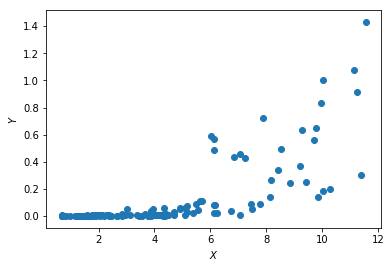

In [22]:
plt.scatter(data['X'],data['Y'])
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.show()

### adding 2 outliers



In [23]:
data = data.append({"Date":"01/01/18","Year":"2018", "X":12, "Y":5}, ignore_index=True)
data = data.append({"Date":"10/01/18","Year":"2018", "X":8, "Y":4}, ignore_index=True)
data.tail()

,Date,Year,X,Y
120,06/12/97,1997,5.688951,0.111158
121,06/13/97,1997,5.089397,0.058052
122,06/13/97,1997,4.918480,0.049870
123,01/01/18,2018,12.000000,5.000000
124,10/01/18,2018,8.000000,4.000000


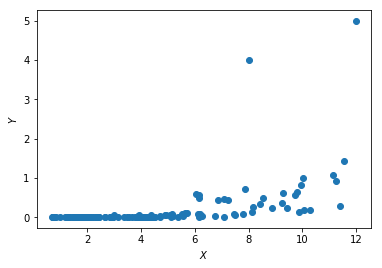

In [24]:
plt.scatter(data['X'],data['Y'])
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.show()

The key of TF implementation is to understand computation graph, session , operation and palceholder.

In [25]:
import tensorflow as tf
from sklearn import linear_model

"""
parameters
"""
sample_rate = 0.3 # rondom sampling rate for each batch. 
#It does not have much capacity and probably not much worry about overfitting. 1.0 should be fine.
epoc = 500
input_dim = 1 # number of input dimention(variables)
h1_dim = 3 # potential number of segments-1
lamda = 0.0001 # L1 reglurarization
lr=0.001 #learning rate

"""
fromatting numpy array
"""
X = np.array(data.X).reshape(-1,input_dim)
Y = np.array(data.Y).reshape(-1,1)


"""
Util functions
"""
# next batch from stack overflow
def next_batch(rate, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[: int(len(data)*rate)]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

"""
helping search with a good initial values
"""
lreg = linear_model.LinearRegression()
lreg.fit(X, Y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
from datetime import datetime
import os

exptitle = 'MyFirstModel'
results_path = './Results'

def form_results():
    """
    Forms folders for each run to store the tensorboard files and saved models.
    """
    folder_name = "/{0}_{1}".format(datetime.now().strftime("%Y%m%d%H%M%S"),exptitle)
    tensorboard_path = results_path + folder_name + '/Tensorboard'
    saved_model_path = results_path + folder_name + '/Saved_models/'
    print(results_path + folder_name)
    if not os.path.exists(results_path + folder_name):
        os.makedirs(results_path + folder_name)
        os.makedirs(tensorboard_path)
        os.makedirs(saved_model_path)
    return tensorboard_path, saved_model_path

./Results/20181018194737_RobustnessTest/Saved_models/
INFO:tensorflow:Restoring parameters from ./Results/20181018194737_RobustnessTest/Saved_models/-499


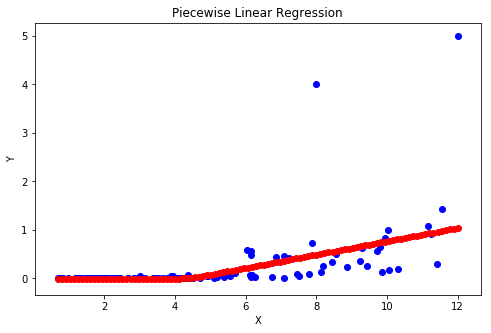

In [31]:
import tensorflow as tf
from sklearn import linear_model

exptitle = 'RobustnessTest'
mode = 0 # 1: training, 0:loading model
model_loc = '/20181018194737_RobustnessTest/Saved_models/'
"""
parameters
"""
sample_rate = 0.3 # rondom sampling rate for each batch. 
#It does not have much capacity and probably not much worry about overfitting. 1.0 should be fine.
epoc = 500
input_dim = 1 # number of input dimention(variables)
h1_dim = 3 # potential number of segments-1
lamda = 0.001 # L1 reglurarization
lr=0.001 #learning rate

"""
tensorflow graph
"""
# reset graph
tf.reset_default_graph()

# Placeholders for input data and the targets
x_ph  = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='Input')
y_ph = tf.placeholder(dtype=tf.float32, shape=[None,1], name='Output')

w = tf.get_variable("weight", shape=[input_dim,h1_dim],
                    initializer=tf.random_normal_initializer(mean=lreg.coef_[0][0]/h1_dim,stddev=0.001))
b = tf.get_variable('bias1', shape = [1,h1_dim],
                    initializer=tf.random_normal_initializer(mean=lreg.intercept_[0]/h1_dim, stddev=0.001))
c = tf.get_variable('bias2', shape = [1,1],
                    initializer=tf.random_normal_initializer(mean=0, stddev=0.001))

h = tf.nn.relu(tf.add(tf.matmul(x_ph, w),b))
y = tf.reduce_sum(h, axis = 1)+c

L1 = tf.reduce_sum(tf.abs(w))
loss = tf.losses.mean_squared_error(y_ph, tf.reshape(y,(-1,1)))+lamda*L1
opt = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)

init = tf.global_variables_initializer()

"""
Tensorboard scalar
"""
sm_L1 = tf.summary.scalar(name='L1', tensor=L1) ######
sm_loss = tf.summary.scalar(name='mse_loss', tensor=loss) ######
summary_op = tf.summary.merge_all() ######

"""
training
"""
steps = -1
saver = tf.train.Saver() ######
with tf.Session() as sess:  
    if mode == 1:
        sess.run(init)
        tensorboard_path, saved_model_path = form_results()   ######
        writer = tf.summary.FileWriter(logdir=tensorboard_path, graph=sess.graph) ######
        for i in range(epoc):
            steps += 1
            batch_x, batch_y = next_batch(sample_rate,X,Y)          
            _, v_loss = sess.run([opt,loss],feed_dict={x_ph:batch_x ,y_ph:batch_y })
            if i % 10 == 0:######
                print("------------------Epoch {}/{} ------------------".format(i, epoc))
                smv_L1,smv_loss = sess.run([sm_L1,sm_loss],feed_dict={x_ph:batch_x ,y_ph:batch_y })######
                writer.add_summary(smv_L1, global_step=steps)   ######
                writer.add_summary(smv_loss, global_step=steps) ######
                print("loss = {}".format(v_loss))

        writer.close() ######
        y_hat = sess.run([y],feed_dict={x_ph:X})
        y_hat = np.asarray(y_hat).reshape(-1,1)
        X_slice = np.linspace(np.amin(X), np.amax(X), num=100).reshape(-1,1)
        Y_slice_hat = sess.run([y],feed_dict={x_ph:X_slice})
        Y_slice_hat = np.asarray(Y_slice_hat).reshape(-1,1)
        np.savetxt("yhat.csv", np.concatenate((X,Y,y_hat),axis=1),header="X, Y, Yhat", delimiter=",")
        saver.save(sess, save_path=saved_model_path, global_step=steps,write_meta_graph = True)######
    if mode ==0: ######
        print(results_path + model_loc)
        saver.restore(sess, save_path=tf.train.latest_checkpoint(results_path + model_loc))
        X_slice = np.linspace(np.amin(X), np.amax(X), num=100).reshape(-1,1)
        Y_slice_hat = sess.run([y],feed_dict={x_ph:X_slice})
        Y_slice_hat = np.asarray(Y_slice_hat).reshape(-1,1)
        """
        graph
        """
        fig, ax = plt.subplots(figsize=(8,5))
        ax.scatter(X, Y, color='blue')
        ax.scatter(X_slice, Y_slice_hat, color='red')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        plt.title('Piecewise Linear Regression')
        plt.show()

### fire up the Tensorboard

tensorboard --logdir=./Results

